# Drift Monitoring with the Howso Engine

## Overview

This recipe will demonstrate Howso Engine’s ability to handle and monitor model drift. Drift occurs when a trained model's testing data experiences a shift in distribution which often causes model performance to decline. Howso Engine can be used to monitor any potential drift by evaluating bias in both new and ongoing models using online learning and interpretability. By using online learning and the Engine's interpretability, users can pair the Howso Engine alongside their deployed deep-learning models to get early indicators when incoming data is beginning to indicate a new distribution or model performance is decreasing.

Additionally, the Howso Engine's interpretability may be able to help users understand the source of model drift, whether it be a shift in distribution or simply a shift in performance.

## Step 1: Load the Data

In [1]:
import os

import numpy as np
import pandas as pd
import plotly.io as pio
import pmlb
from scipy.stats import entropy
from sklearn.ensemble import GradientBoostingClassifier

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import (
    plot_drift,
    plot_kl_divergence,
)

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

In this recipe we will use the well known Iris dataset. 

In [2]:
df = pmlb.fetch_data('iris', local_cache_dir='data/pmlb')
df

,sepal-length,sepal-width,petal-length,petal-width,target
0,6.7,3.0,5.2,2.3,2
1,6.0,2.2,5.0,1.5,2
2,6.2,2.8,4.8,1.8,2
3,7.7,3.8,6.7,2.2,2
4,7.2,3.0,5.8,1.6,2
...,...,...,...,...,...
145,5.0,3.5,1.6,0.6,0
146,5.4,3.9,1.7,0.4,0
147,5.1,3.4,1.5,0.2,0
148,5.0,3.6,1.4,0.2,0


## Step 2: Simulate Data Drift

Model drift occurs when the model that has been trained no longer captures the relationships of incoming data. In this case, we will sample from the data in such a way that certain targets are much less likely to appear in our test and observation sets than in the training set. This will simulate model drift and allow us to demonstrate Howso Engine.

Specifically, we will hold an entire class out of the training data. Then we will slowly expose the model to data of the untrained class, measuring how well the model adjusts to the new distribution of data. Additionally, the data of the untrained class will consist of some missing values for the action feature.

In [3]:
df_biased = df[df['target'].isin([1,2])]
df_train = df_biased.sample(frac=0.5)
df_test_no_drift = df_biased[~df_biased.isin(df_train)].dropna()
df_test_drift = df[~df.isin(df_biased)].dropna()
df_test_drift.loc[df_test_drift.sample(frac=0.2).index, "target"] = np.nan

df_test = pd.concat([df_test_no_drift, df_test_drift])

print('Train Dataset "Target" Distribution: ')
display(df_train.target.value_counts().sort_index())
print("=" * 30)

print('\nNo Drift Test Dataset "Target" Distribution: ')
display(df_test_no_drift.target.value_counts().sort_index())
print("=" * 30)

print('\nDrift Test Dataset "Target" Distribution: ')
display(df_test_drift.target.value_counts(dropna=False).sort_index())
print("=" * 30)

Train Dataset "Target" Distribution: 


target
1    28
2    22
Name: count, dtype: int64


No Drift Test Dataset "Target" Distribution: 


target
1.0    22
2.0    28
Name: count, dtype: int64


Drift Test Dataset "Target" Distribution: 


target
0.0    40
NaN    10
Name: count, dtype: int64

## Step 3: Configure Feature Attributes

Configure the feature attributes and inspect them to verify they are correct.

In [4]:
features = infer_feature_attributes(df)
features['pred'] = features['target'].copy()
feature_names = df.columns.tolist()
action_features = feature_names[-1:]
context_features = feature_names[:-1]

features

{'sepal-length': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 2.7, 'max': 20.1}},
 'sepal-width': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 7.4}},
 'petal-length': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 1.0, 'max': 7.4}},
 'petal-width': {'type': 'continuous',
  'decimal_places': 1,
  'original_type': {'data_type': 'numeric', 'size': 8},
  'bounds': {'min': 0.0, 'max': 2.7}},
 'target': {'type': 'nominal',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}},
 'pred': {'type': 'nominal',
  'data_type': 'number',
  'decimal_places': 0,
  'original_type': {'data_type': 'integer', 'size': 8},
  'bounds': {'allow_null': False}}}

## Step 4: Train the non-Howso Model

The non-Howso model will be trained on the training set created above. The training order will be recorded as a feature as well to the Howso model to help monitor drift.

In [5]:
gb = GradientBoostingClassifier()
gb.fit(df_train[context_features].values, df_train[action_features].values.reshape(-1))

# Use predicted features to inform Howso Engine

df_test['target'] = df_test['target']
df_test = df_test.reset_index(drop=True)
df_test = df_test.reset_index()

df_train = df_train.reset_index(drop=True)
df_train = df_train.reset_index()

df_test

,index,sepal-length,sepal-width,petal-length,petal-width,target
0,0,6.7,3.0,5.2,2.3,2.0
1,1,6.0,2.2,5.0,1.5,2.0
2,2,6.2,2.8,4.8,1.8,2.0
3,3,7.7,3.8,6.7,2.2,2.0
4,4,7.2,3.0,5.8,1.6,2.0
...,...,...,...,...,...,...
95,95,5.0,3.5,1.6,0.6,0.0
96,96,5.4,3.9,1.7,0.4,NaN
97,97,5.1,3.4,1.5,0.2,0.0
98,98,5.0,3.6,1.4,0.2,0.0


## Step 5: Train the Howso Model

First, the Howso model will be trained on the modified data set trained above. 

Then we leverage online learning to record explanations with each case that is trained. We make sure to use the predicted target from the non-Howso model as well as the index to diversify the ways in which we can monitor the model. The index allows us to determine whether or not the time at which a given case was trained is important for prediction, which could indicate drift, while the predicted target allows us to note disagreements between the two models.

Notably, we are enabling the Auto-Analyze feature on our Trainee. This will force the Trainee to do an Analyze automatically at certain increments of training data. In the case of this demonstration we set an `analyze_threshold` of 1. In most practical use-cases, this would be a prohibitively expensive operation. Auto-analyze is still appropriate in many use-cases, but larger `analyze_thresholds` are typically recommended.

In [6]:
# Create and train a Trainee
mismatch_counts = []

features = infer_feature_attributes(df_test)
new_context_features = None

familiarity_convictions_hse = []
familiarity_convictions_gb = []

# Create trainee and turn on auto-analyze
t = engine.Trainee("Engine - Drift Monitoring Recipe", features, overwrite_existing=True)
t.train(df_train)
t.analyze()
t.set_auto_analyze_params(analyze_threshold=1, auto_analyze_enabled=True)
for idx, case in df_test.iterrows():
    # Define which details we want from the Howso model
    details = {
        'feature_mda': True
    }

    # Predict using the gradient booster
    pred_gb = gb.predict(case[context_features].values.reshape(1, -1))[0]
    gb_case = case.copy()
    gb_case.target = pred_gb

    # Define the updated context features
    if new_context_features is None:
        new_context_features = [col for col in case.index if col not in action_features]

    # React on the new case
    result = t.react(case[new_context_features].values.reshape(1, -1),
                     action_features=action_features,
                     context_features=new_context_features,
                     details=details)
    action = result['action']
    explanation = result['details']


    # Store the Howso prediction
    pred_hse = action.iloc[0, 0]

    # Compute familiarity conviction for case
    f_conv = t.react_group(new_cases=[[case.values.tolist()], [gb_case.values.tolist()]], features=df_test.columns.tolist())
    f_conv_hse = f_conv['familiarity_conviction_addition'].iloc[0]
    f_conv_gb = f_conv['familiarity_conviction_addition'].iloc[1]
    familiarity_convictions_hse.append(f_conv_hse)
    familiarity_convictions_gb.append(f_conv_gb)


    if pred_hse != pred_gb:
        mismatch_counts.append(1)
    else:
        mismatch_counts.append(0)

    if pred_hse != pred_gb and f_conv_hse < 0.5 * np.mean(familiarity_convictions_hse) and idx > 30:
        print(f"Case {idx} is anomalous.")

        display(case)
        hse_importances = [val for key, val in explanation['feature_mda'][0].items() if key in context_features]
        gb_importances = gb.feature_importances_.tolist()
        print(f"ENGINE feature importance: {[context_features[i] for i in np.argpartition(hse_importances, -3)[-3:]]}")
        print(f"MODEL feature importance  : {[context_features[i] for i in np.argpartition(gb_importances, -3)[-3:]]}")
        print("\n=====\n")

    # Train on the new case
    case['pred'] = pred_gb
    t.train([case.values.tolist()], features=case.index.tolist())

Version 17.0.0 of Howso Engine™ is available. You are using version 16.1.0.


Case 45 is anomalous.


index           45.0
sepal-length     4.9
sepal-width      2.4
petal-length     3.3
petal-width      1.0
target           1.0
Name: 45, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 51 is anomalous.


index           51.0
sepal-length     4.9
sepal-width      3.1
petal-length     1.5
petal-width      0.1
target           0.0
Name: 51, dtype: float64

ENGINE feature importance: ['petal-width', 'petal-length', 'sepal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====

Case 53 is anomalous.


index           53.0
sepal-length     4.8
sepal-width      3.1
petal-length     1.6
petal-width      0.2
target           NaN
Name: 53, dtype: float64

ENGINE feature importance: ['sepal-width', 'sepal-length', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 57 is anomalous.


index           57.0
sepal-length     5.1
sepal-width      3.5
petal-length     1.4
petal-width      0.3
target           NaN
Name: 57, dtype: float64

ENGINE feature importance: ['petal-width', 'petal-length', 'sepal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====

Case 59 is anomalous.


index           59.0
sepal-length     5.5
sepal-width      4.2
petal-length     1.4
petal-width      0.2
target           0.0
Name: 59, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====

Case 60 is anomalous.


index           60.0
sepal-length     5.1
sepal-width      3.8
petal-length     1.9
petal-width      0.4
target           0.0
Name: 60, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 61 is anomalous.


index           61.0
sepal-length     4.9
sepal-width      3.1
petal-length     1.5
petal-width      0.1
target           0.0
Name: 61, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====

Case 62 is anomalous.


index           62.0
sepal-length     5.4
sepal-width      3.9
petal-length     1.3
petal-width      0.4
target           0.0
Name: 62, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 63 is anomalous.


index           63.0
sepal-length     5.1
sepal-width      3.5
petal-length     1.4
petal-width      0.2
target           0.0
Name: 63, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 64 is anomalous.


index           64.0
sepal-length     4.8
sepal-width      3.4
petal-length     1.9
petal-width      0.2
target           0.0
Name: 64, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 65 is anomalous.


index           65.0
sepal-length     5.4
sepal-width      3.4
petal-length     1.5
petal-width      0.4
target           0.0
Name: 65, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 66 is anomalous.


index           66.0
sepal-length     5.0
sepal-width      3.5
petal-length     1.3
petal-width      0.3
target           NaN
Name: 66, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 67 is anomalous.


index           67.0
sepal-length     4.5
sepal-width      2.3
petal-length     1.3
petal-width      0.3
target           0.0
Name: 67, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 68 is anomalous.


index           68.0
sepal-length     5.1
sepal-width      3.8
petal-length     1.5
petal-width      0.3
target           NaN
Name: 68, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 78 is anomalous.


index           78.0
sepal-length     5.2
sepal-width      4.1
petal-length     1.5
petal-width      0.1
target           NaN
Name: 78, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 83 is anomalous.


index           83.0
sepal-length     5.4
sepal-width      3.7
petal-length     1.5
petal-width      0.2
target           NaN
Name: 83, dtype: float64

ENGINE feature importance: ['petal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 88 is anomalous.


index           88.0
sepal-length     5.7
sepal-width      4.4
petal-length     1.5
petal-width      0.4
target           NaN
Name: 88, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



Case 96 is anomalous.


index           96.0
sepal-length     5.4
sepal-width      3.9
petal-length     1.7
petal-width      0.4
target           NaN
Name: 96, dtype: float64

ENGINE feature importance: ['sepal-length', 'sepal-width', 'petal-width']
MODEL feature importance  : ['petal-length', 'sepal-length', 'petal-width']

=====



## Step 6: Inspect the "Deployed" the non-Howso Model

We now will inspect the "Deployed" the GB model, observing the results as it iterated through the test set, getting predictions from both the non-Howso and Howso model. Explanations are recorded at each step, and anomalous cases are brought to the forefront including feature importance and predictions. The Howso model learns from this information as each new case is predicted. The non-Howso model is not updated online.

Inspecting the plot of conviction over time, we are able to see clear drop once the test set that simulates model drift begins being predicted upon. Furthermore, we see that the Howso Engine model is able to recuperate and begin to learn the new drifted data distribution quickly which brings it's conviction back up. However, since the non-Howso model is not trained online, its conviction does not come back up.

> Note: Conviction is a ratio of expected surprisal to observed surprisal. So when we see the conviction above 1.0, this indicates that the data is not surprising which indicates it is well understood and characterized by the model. In contrast, conviction below 1.0 indicates the opposite, or that the model is unusually surprised by those values.

*The beginning of model drift is made very clear by the drop in familiarity conviction.*

This demo was created in such a way to make the effects of drift very obvious. It should typically be more subtle with a real-world model.

/home/runner/.local/lib/python3.11/site-packages/kaleido/scopes/base.py:188: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



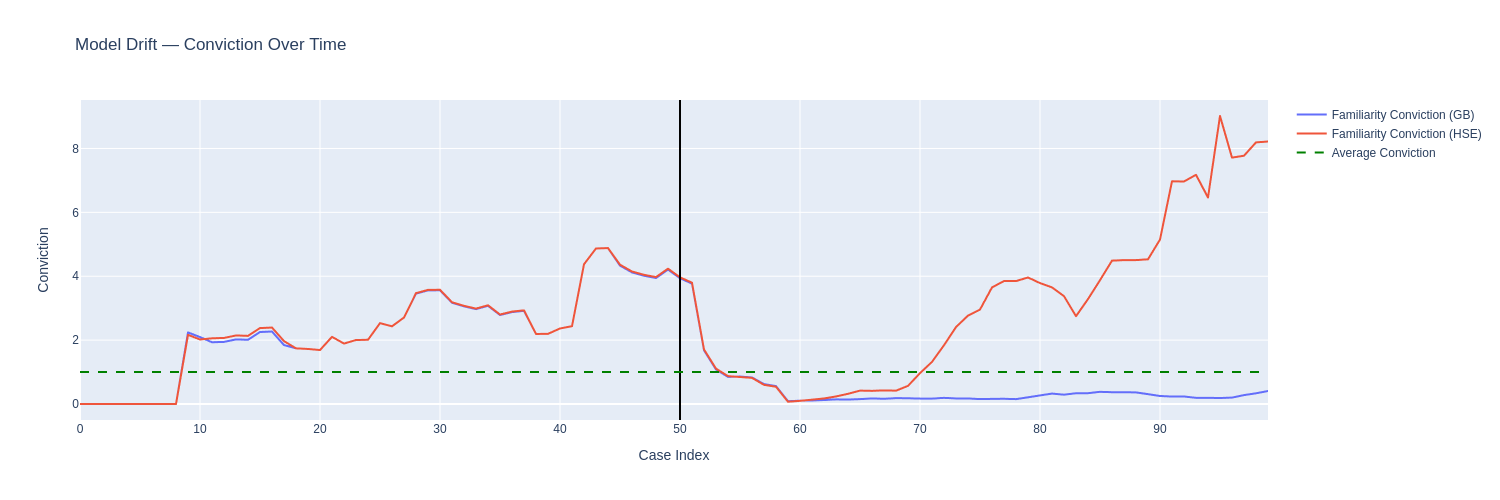

In [7]:
f_conv_df = pd.DataFrame(familiarity_convictions_hse, columns=["Familiarity Conviction (HSE)"])
f_conv_df["Familiarity Conviction (GB)"] = familiarity_convictions_gb

fig = plot_drift(f_conv_df, line_positions=[len(df_test_no_drift)])
fig.add_hline(1, line_dash='dash', line_color='green', name='Average Conviction', showlegend=True)
fig.update_layout(width=1500)
fig.show()

Lastly, we compute the mean difference in convictions between the case values and predictions of both the Howso model and the non-Howso Model. We see that the mean difference in conviction is quite significant once we get into the data that represents the model drift.

This type of measure can be used as an indicator that there is concern for model drift, which would call for more careful human inspection.

In [8]:
# calculate delta conviction between Howso vs. GB model
conv_delta = f_conv_df['Familiarity Conviction (HSE)'] - f_conv_df['Familiarity Conviction (GB)']

# calculate average delta for the latter portion of the data (after drift occurred)
avg_delta = conv_delta[50:].mean()
avg_delta

3.2312248532404646

Another way to measure the model drift in this scenario is to measure how often the two models disagree with one another. We should see that before the final test set kicks in (index=50), the models do not disagree often on predictions. 

However, once the drifted data begins being predicted, we see many more disagreements. This makes clear sense since the Howso model was trained online and could adjust to the drifted data where the other model could not. The increased level of disagreement can serve as another strong signal to stakeholders that their deployed models are experiencing model drift as the accompanying online model began to capture new relationships in the data while the pretrained model was falling behind.

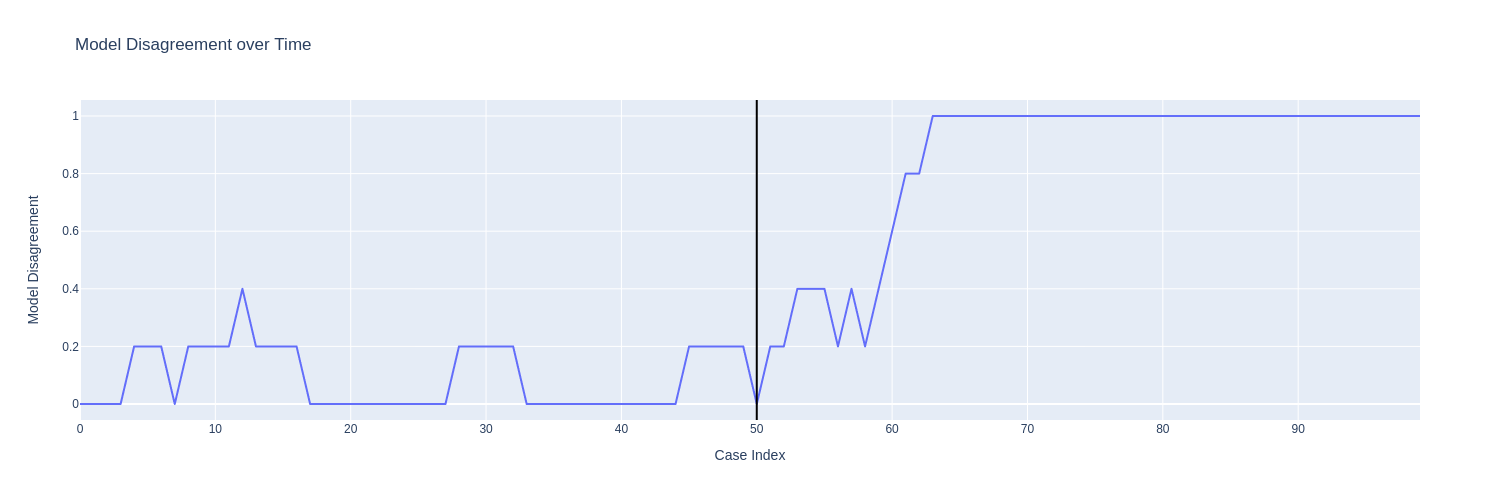

In [9]:
mismatch_count_df = pd.DataFrame(mismatch_counts, columns=["Prediction Deviation"])

fig = plot_drift(mismatch_count_df, line_positions=[len(df_test_no_drift)], rolling_window=5, yaxis_title='Model Disagreement', title="Model Disagreement over Time")
fig.update_layout(width=1500)
fig.show()

And lastly, we compute the difference in the level of differing predictions before the drifted data testing and during the drifted data testing. This clearly shows a significant increase in the level of disagreement between the models which indicates to users that their deployed model may need to be updated or retrained with an updated dataset that better reflects the incoming data.

In [10]:
# extract the series
mismatch_series = mismatch_count_df['Prediction Deviation']

# calculate before and after drift mismatch
after_drift = mismatch_series.iloc[50:].mean()
before_drift = mismatch_series.iloc[:50].mean()

avg_pred_mismatch = after_drift - before_drift
avg_pred_mismatch

0.78

## Conclusion

Model drift is a pervasive and costly problem across the industry of applied machine learning. This issue is exacerbated with the rising popularity of pre-trained models that are not designed to learn online and demand costly training cycles to update.

This recipe serves as a curated example of how the Howso Engine can be used to accompany a deployed pretrained model to help give users strong signals of model drift so that the appropriate actions can be taken whether it be switching to an online model, retraining their model, or temporarily disabling their deployed models. 

Lastly, this recipe just proposes a couple methods of how model drift could be monitored using the Howso Engine. The Engine provides a plethora of interpetability and explainability tools that users can leverage to better understand the data in their system, which many of could be used to monitor model drift in different ways.